# OCI Data Science - Merge

Befor using this notebook users have to download neccessary data. We've collected/downloaded the data in advance by usiltizing `00 pull data.ipunb` notebook and saved them to `data` folder. This helps to save time though data-download may take a few hours.

This notebook creates final dataset which is utilized for model training and testing.

## Contents:

* <a href='#intro'>Introduction</a>
* <a href='#weatherdata'>weather data</a>
* <a href='#lapsdata'>laps data</a>
* <a href='#resultdata'>results data</a>
* <a href='#Joindata'>merge weather and lap data</a>
* <a href='#plotsamplelapdata'>plot sample lap data</a>
* <a href='#Summarize'>Create Final Train/Test Data</a>
* <a href='#AddTrackInfo'>Merge with Track Info</a>

<a id='intro'></a>
## Introduction

The data have already been saved in `data` folder. The data of intrest has `.pickle` extension and they are raw which requires preprocessed and prepared for feature extraction and model building.

This notebook only focuses on reading varios data and merging them into a single DataFrame.

#### Load packages

In [1]:
path = '/home/datascience/WorkSpace/RedBull-Racining-TimeToPit/notebooks'
data_path = '../../RedBull/data/'

In [2]:
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

<a id='weatherdata'></a>
## Weather Data
Weather data is available in session level and its time stamp is not aligned with laps-data.


In [3]:
file = open(data_path+'weathers_data.pickle','rb')
df_weather = pickle.load(file)
df_weather['eventYear'] = pd.DatetimeIndex(df_weather['EventDate']).year

<a id='resultdata'></a>
## Results

Load data and select.

Dropping non-race and non-qual rows from results data and keeping the following columns:
`'Position','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','EventName','eventYear','session','TimeSec'`

In [4]:
file = open(data_path+'results_data.pickle','rb')
df_res = pickle.load(file)

df_res['eventYear'] = pd.DatetimeIndex(df_res['EventDate']).year
df_res['Q1Sec'] = df_res['Q1']/np.timedelta64(1, 's')
df_res['Q2Sec'] = df_res['Q2']/np.timedelta64(1, 's')
df_res['Q3Sec'] = df_res['Q3']/np.timedelta64(1, 's')
df_res['TimeSec'] = df_res['Time']/np.timedelta64(1, 's')


## keep only race and qual data
df_res = df_res[(df_res['session']=='Race') | (df_res['session']=='Qualifying')]
print('df_res size is: ', df_res.shape)
print('-'*100,'\n')

df_res= df_res[['Position','GridPosition','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','Abbreviation',
                'EventName','eventYear','session','Time','TimeSec','TeamName', 'EventDate']]


df_res size is:  (3618, 27)
---------------------------------------------------------------------------------------------------- 



<a id='lapsdata'></a>
## Laps Data

Load Lap data and convert times to useable format

In [5]:
file = open(data_path+'laps_data.pickle','rb')
drop_cols = ['Sector1Time','Sector2Time','Sector3Time',
             'Sector1SessionTime','Sector2SessionTime','Sector3SessionTime',
            'SpeedI1','SpeedI2','SpeedFL', 'IsAccurate']

df_laps = pickle.load(file).drop(drop_cols,axis=1).reset_index(drop=True)

df_laps['eventYear'] = pd.DatetimeIndex(df_laps['EventDate']).year
df_laps['lapTimeSec'] = df_laps['LapTime']/np.timedelta64(1, 's')


<a id='Joindata'></a>
### Merge weather and lap data

In [6]:
## Weather and Laps data are not time-aligned and each have their own 
## 
df_weather = df_weather.sort_values( ['EventName','eventYear','session', 'Time']).reset_index(drop=True)
df_laps = df_laps.sort_values( ['EventName','eventYear','session','Team','Driver', 'Time']).reset_index(drop=True)

LapsColumns = ['EventName','eventYear','Team','session','Driver',
               'Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'LapStartTime', 'TrackStatus',
       'LapStartDate',  'country', 'EventDate','lapTimeSec']

In [7]:
%%time
def func_merger_lap_weather(d_f):
    '''
    func_merger_lap_weather method merges weather and laps data
    it returns all columns after merge
    '''    
    
    d_f = d_f.sort_values('Time').reset_index(drop=True)
    
    EventName = np.unique(d_f['EventName'])[0]
    session = np.unique(d_f['session'])[0]
    eventYear = np.unique(d_f['eventYear'])[0]
    Driver = np.unique(d_f['Driver'])
    
    sub_weather = df_weather[(df_weather['EventName']==EventName) &
                            (df_weather['session']==session) &
                            (df_weather['eventYear']==eventYear) ].sort_values('Time').reset_index(drop=True)
    
    sub_result = df_res[(df_weather['EventName']==EventName) &
                            (df_weather['session']==session) &
                            (df_weather['eventYear']==eventYear) ].sort_values('Time').reset_index(drop=True)
    
    d_f_merged = pd.merge_asof(d_f, sub_weather, 
                          on="Time", direction='nearest',
                         suffixes=('', '_drop'))
    d_f_merged.drop([col for col in d_f_merged.columns if 'drop' in col], axis=1, inplace=True)
    
#     print(d_f.shape,Driver, len(d_f_merged), EventName , eventYear, np.unique(d_f['Team']), 
#           session, len(df_weather))
    weather_cols = ['WindSpeed', 'AirTemp','Humidity', 'Pressure','TrackTemp','Rainfall','WindDirection']
    laps_cols = ['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'RoundNumber',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife','FreshTyre', 'LapStartTime', 'TrackStatus',
       'LapStartDate',  'country', 'EventDate','lapTimeSec']
    laps_cols.extend(weather_cols) 
    
    return  d_f_merged[laps_cols]

df_lapWeather = df_laps.groupby(['EventName', 'eventYear','Team','session','Driver'])[LapsColumns].apply(func_merger_lap_weather).reset_index()

/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


CPU times: user 11min, sys: 875 ms, total: 11min 1s
Wall time: 11min 7s


<a id='plotsamplelapdata'></a>
### Plot a sample race lap-data

In [8]:
sub_lap = df_lapWeather[(df_lapWeather['EventName']=='Abu Dhabi Grand Prix') &
        (df_lapWeather['Team']=='Red Bull Racing') &
        (df_lapWeather['session']=='Race') &
       (df_lapWeather['eventYear']==2021) &
        (df_lapWeather['Driver']=='PER')].sort_values('Time').reset_index(drop=True) #(df_laps['Driver']=='PER')

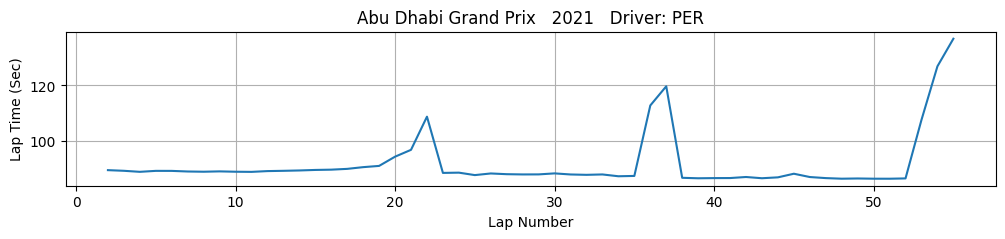

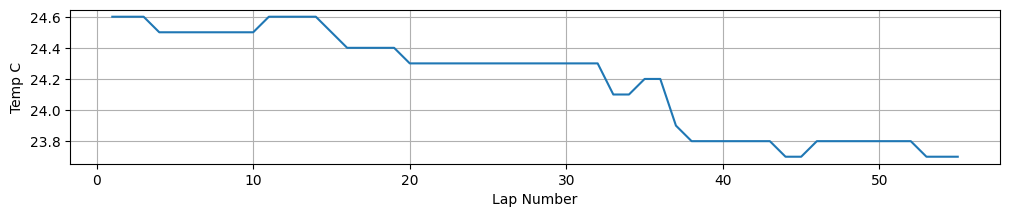

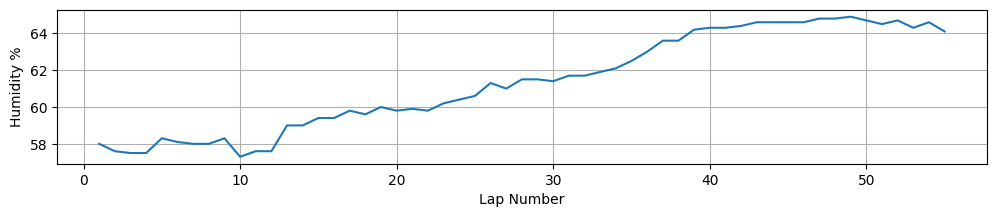

In [9]:
fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['lapTimeSec'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (Sec)')
plt.title(sub_lap['EventName'][0]+ '   ' +
          str(sub_lap['eventYear'].values[0])+ '   Driver: ' +
          sub_lap['Driver'][0])

fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['AirTemp'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Temp C')

fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['Humidity'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Humidity %')

plt.show()

<a id='Summarize'></a>
## Summarize df_lapWeather and add GridPosition and Position

In [10]:
%%time

lapWeatherCols = df_lapWeather.columns

def Features_PerTyre_PreRace_PerDriver(sub_df):
    
    bestTime=sessionName=meanAirTemp=meanTrackTemp=meanHumid=bestLapTimeSession=GridPosition=Position=TyreLife=Rainfall=np.nan  
    
    raceStintsNums = np.unique(sub_df['Stint'])[0]
    raceTyresComps = np.unique(sub_df['Compound'])
    Driver = np.unique(sub_df['Driver'])[0]
    eventYear = np.unique(sub_df['eventYear'])[0]
    EventName = np.unique(sub_df['EventName'])[0]
    RoundNumber =  np.unique(sub_df['RoundNumber'])[0]

    
    meanAirTemp = np.nanmean(sub_df['AirTemp']) #[sub_df['session']==sessionName] )
    meanTrackTemp = np.nanmean(sub_df['TrackTemp']) #[sub_df['session']==sessionName] )
    meanHumid = np.nanmean(sub_df['Humidity']) #[sub_df['session']==sessionName] )
    Rainfall = np.nanmean(sub_df['Rainfall'])#[sub_df['session']==sessionName] )
    
    GridPosition = df_res['GridPosition'][
                          (df_res['EventName']==EventName)&
                          (df_res['eventYear']==eventYear)&
                          (df_res['Abbreviation']==Driver)&
                          (df_res['RoundNumber']==RoundNumber)&
                          (df_res['session']=='Race')]

    Position = df_res['Position'][
                          (df_res['EventName']==EventName)&
                          (df_res['eventYear']==eventYear)&
                          (df_res['Abbreviation']==Driver)&
                          (df_res['RoundNumber']==RoundNumber)&
                          (df_res['session']=='Race')]
    if len(GridPosition): 
        GridPosition=GridPosition.values[0]
    if len(Position): 
        Position=Position.values[0]
        
    StintLen =[]
    StintLen = len(sub_df)
#     if len(raceStintsNums):
#         for ii in raceStintsNums:
#             StintLen.append(len(sub_df[sub_df['Stint']==ii]) )
    
        
    TyreAge = np.min(sub_df['TyreLife'])
    
    d_f = df_lapWeather[(df_lapWeather['EventName']==EventName)&
                        (df_lapWeather['eventYear']==eventYear)&
                        (df_lapWeather['Driver']==Driver)&
                        (df_lapWeather['RoundNumber']==RoundNumber)&
                        (df_lapWeather['session']=='Qualifying')&
                        (df_lapWeather['Compound']!='raceTyresComps')]
    
    if len(d_f)>0:
        
        bestTime = np.min(d_f['lapTimeSec'])
#         print(bestTime, np.unique(d_f['session']) )
        
        if ~np.isnan(bestTime):
            sessionName = np.unique(d_f['session'][d_f['lapTimeSec']==bestTime])[0]
         

    return pd.Series(data = [bestTime,sessionName, meanAirTemp, meanTrackTemp, meanHumid, Rainfall,
                             GridPosition,Position, raceStintsNums,TyreAge, StintLen], 
                     index=['bestPreRaceTime','bestLapTimeIsFrom','meanAirTemp','meanTrackTemp','meanHumid','Rainfall', 
                            'GridPosition','Position','raceStintsNums','TyreAge','StintLen'])

df_agg = df_lapWeather[df_lapWeather['session']=='Race'].groupby(['EventName','RoundNumber','eventYear','Compound',
                                                            'Driver','Stint']).\
                                                            apply(Features_PerTyre_PreRace_PerDriver).reset_index()

CPU times: user 15min 11s, sys: 96.6 ms, total: 15min 11s
Wall time: 15min 18s


In [11]:
df_agg[df_agg['RoundNumber']==15].reset_index(drop=True).head(2)

,EventName,RoundNumber,eventYear,Compound,Driver,Stint,bestPreRaceTime,bestLapTimeIsFrom,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,raceStintsNums,TyreAge,StintLen
0,Bahrain Grand Prix,15,2020,HARD,ALB,3.0,88.274,Qualifying,25.0,27.000000,69.900000,0.0,4.0,3.0,3.0,22.0,1.0
1,Bahrain Grand Prix,15,2020,HARD,ALB,4.0,88.274,Qualifying,24.7,26.352174,72.952174,0.0,4.0,3.0,4.0,1.0,23.0


<a id='AddTrackInfo'></a>
## Add track info

In [12]:
### Load data
trackInfo = pd.read_csv(data_path+'circuit_length.csv')
df_agg = df_agg.merge(trackInfo, on=['EventName'])

In [13]:
df_agg[df_agg['RoundNumber']==15].reset_index(drop=True).head(2)

,EventName,RoundNumber,eventYear,Compound,Driver,Stint,bestPreRaceTime,bestLapTimeIsFrom,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,raceStintsNums,TyreAge,StintLen,CircuitLength,designedLaps
0,Bahrain Grand Prix,15,2020,HARD,ALB,3.0,88.274,Qualifying,25.0,27.000000,69.900000,0.0,4.0,3.0,3.0,22.0,1.0,5.412,57
1,Bahrain Grand Prix,15,2020,HARD,ALB,4.0,88.274,Qualifying,24.7,26.352174,72.952174,0.0,4.0,3.0,4.0,1.0,23.0,5.412,57


In [14]:
df_agg.to_csv(data_path+'final_data.csv')

### End of Merge Data 